# <p><center style="font-family:newtimeroman;font-size:180%;">Alzheimers Disease Stage Detection (Priyanka Kumari) </center></p>
### Table of contents:

* [Import Libraries](#1)
* [Read Data](#2)
* [Visualization Of Dataset](#3)
* [Data Augmentation](#4)
* [CNN Model](#10)
* [Evaluate The Model](#11)

**<a id="1"></a>
# <p style="font-family:camtasia;font-size:120%;color:purple;text-align:center;border-radius:15px 50px; padding:7px">Import Libraries </p>


In [3]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**<a id="2"></a>
# <p style="font-family:camtasia;font-size:120%;color:purple;text-align:center;border-radius:15px 50px; padding:7px">Read Data </p>


In [4]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset')):
    subfolder_path = os.path.join('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


image             label
0     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
1     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
2     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
3     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
4     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
...                                                 ...               ...
6395  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6396  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6397  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6398  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6399  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented

[6400 rows x 2 columns]

**<a id="3"></a>
# <p style="font-family:camtasia;font-size:120%;color:purple;text-align:center;border-radius:15px 50px; padding:7px">Visualization of Dataset </p>


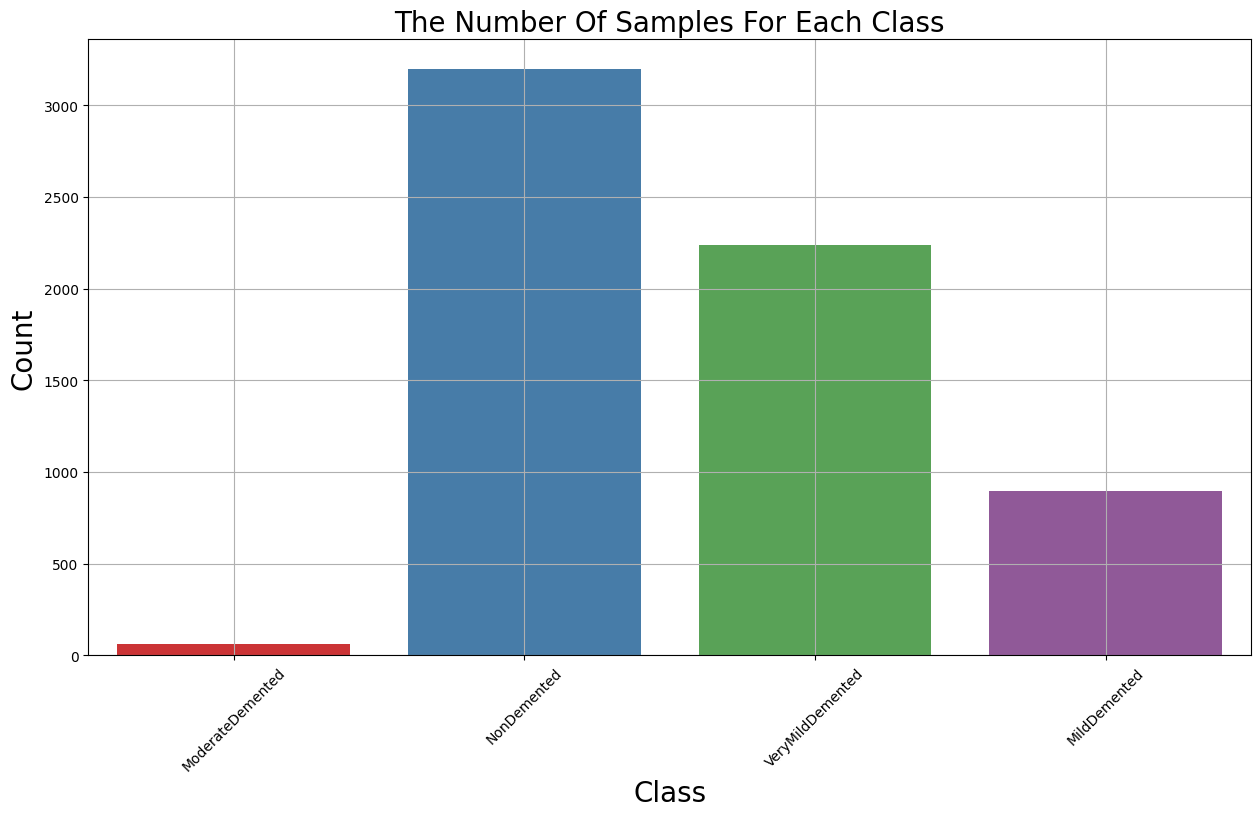

In [5]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

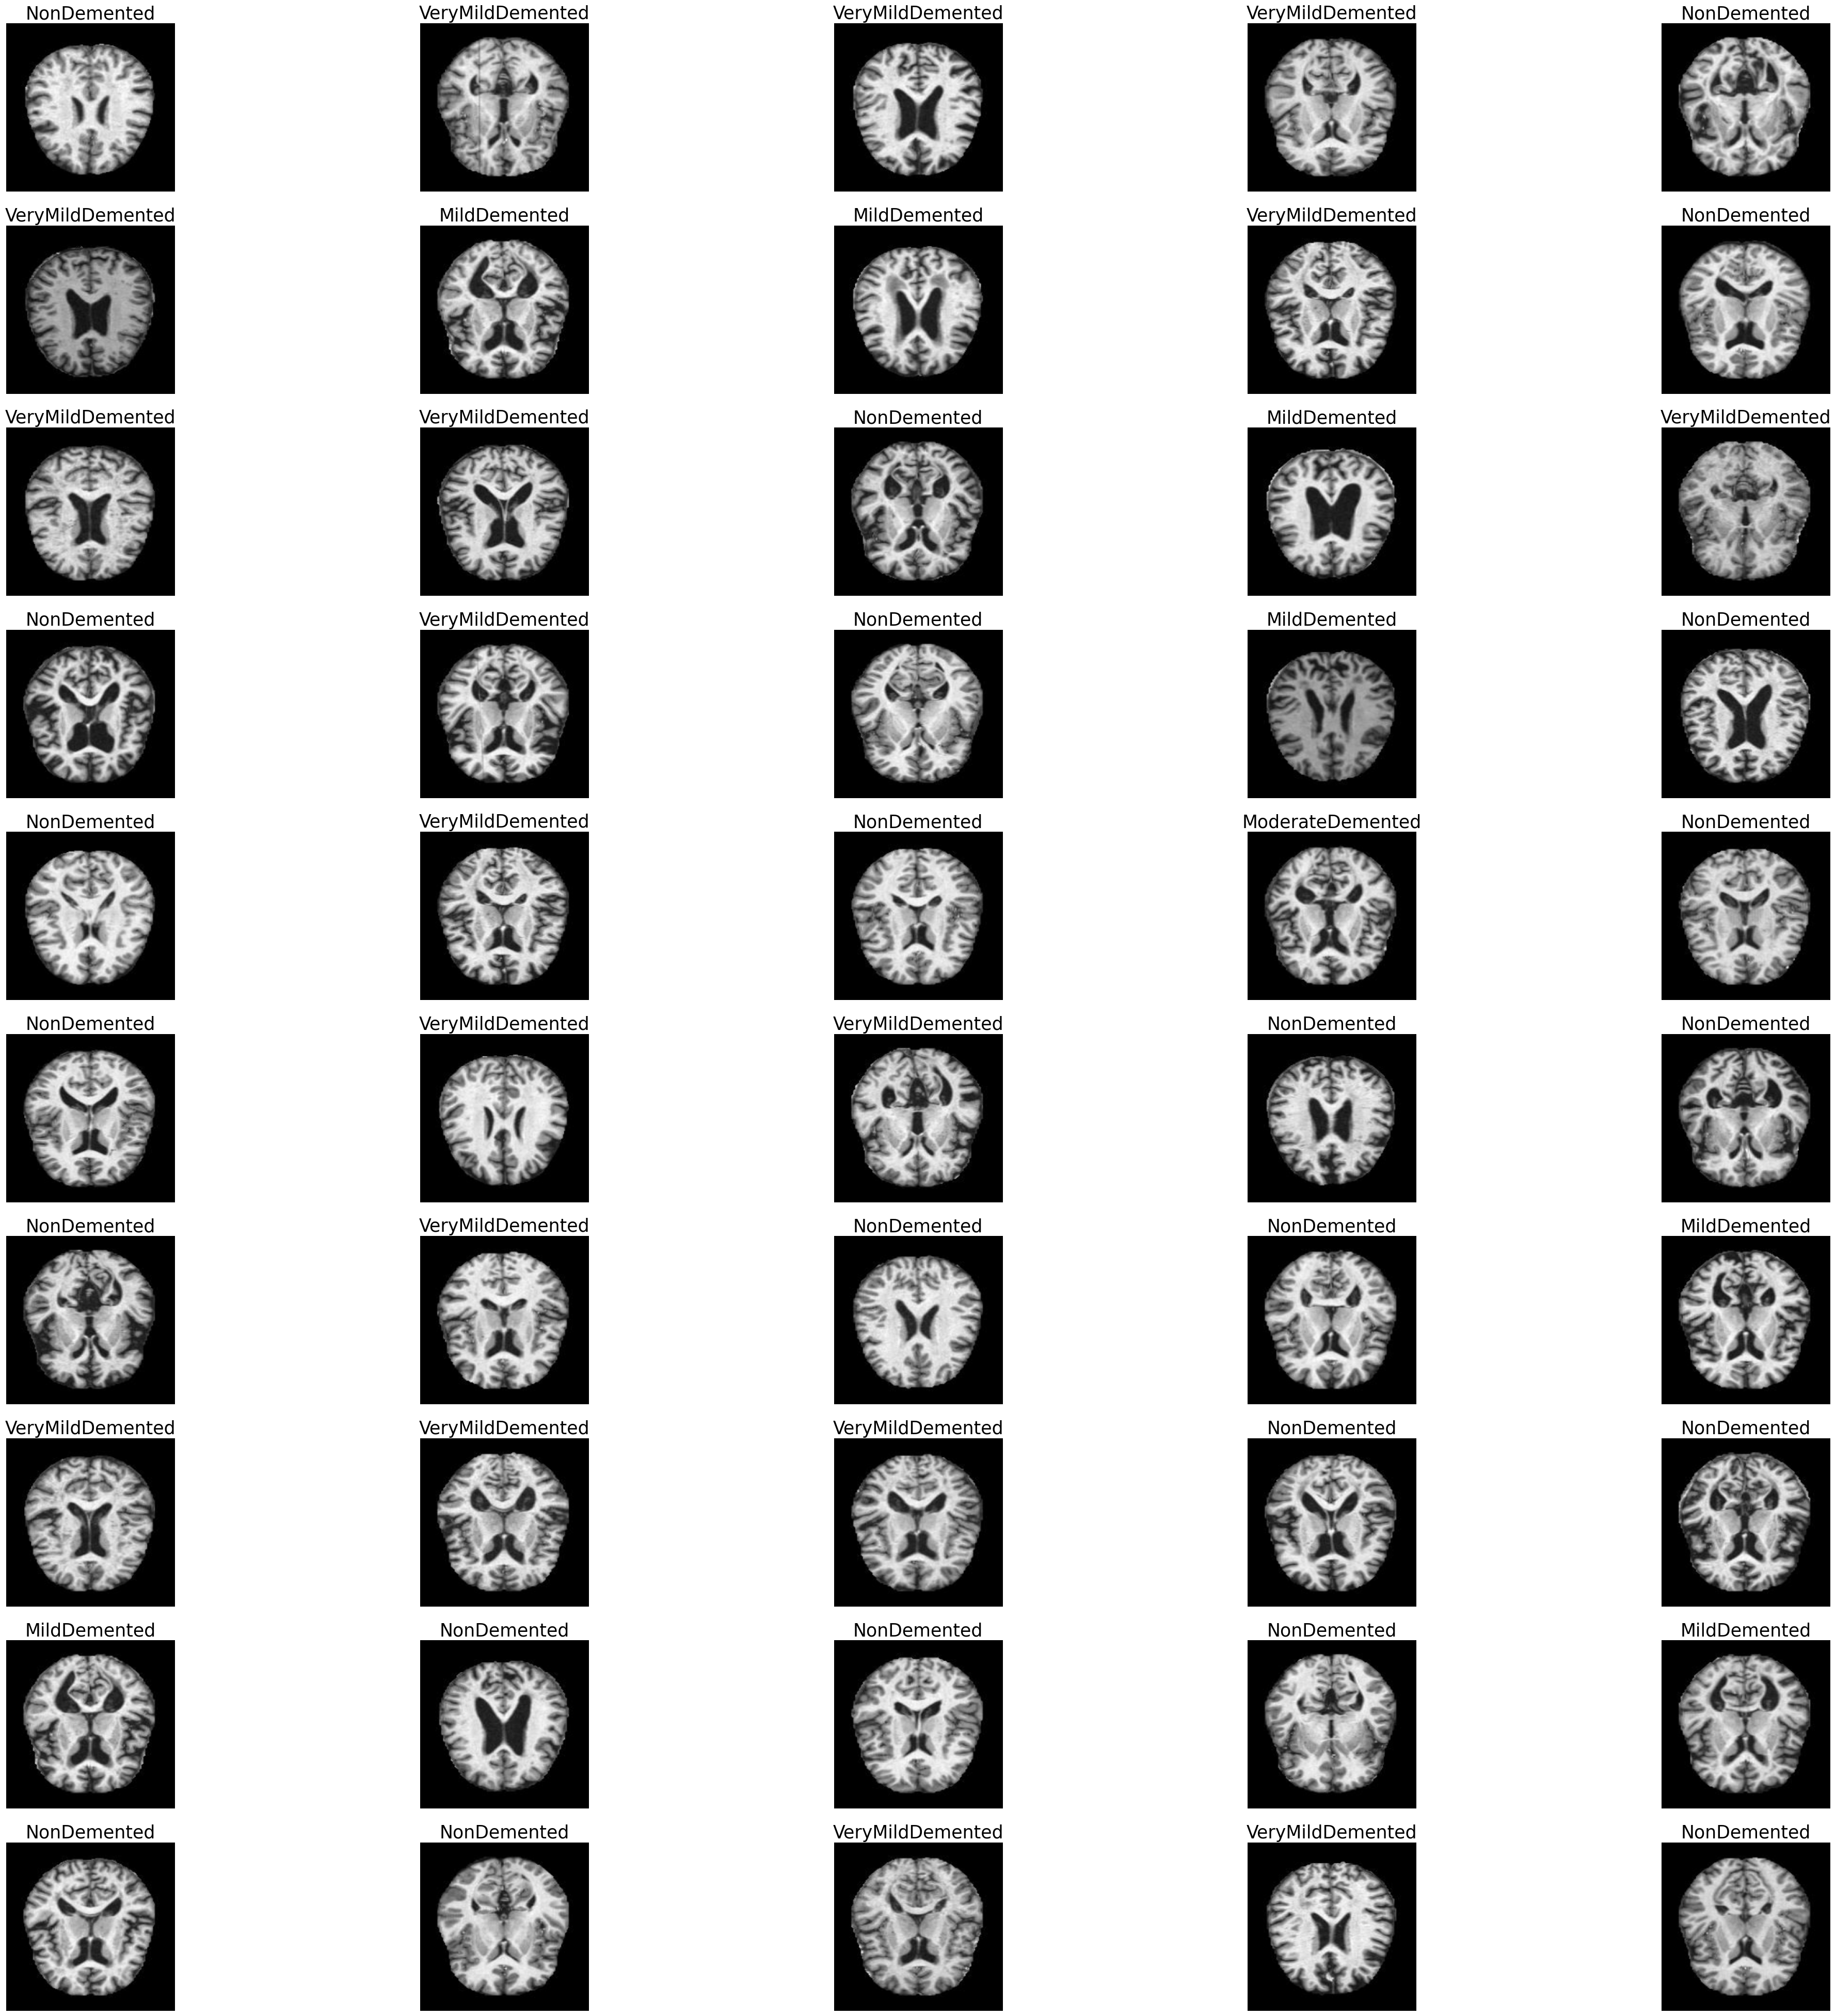

In [6]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

<a id="4"></a>
# <p style="font-family:camtasia;font-size:120%;color:purple;text-align:center;border-radius:15px 50px; padding:7px"> Data Augmentation </p>


In [7]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.


In [8]:
train_data, train_labels = train_data_gen.next()

In [10]:
class_num=np.sort(['Alzheimer_s disease','Cognitively normal','Early mild cognitive impairment','Late mild cognitive impairment'])
class_num

array(['Alzheimer_s disease', 'Cognitively normal',
       'Early mild cognitive impairment',
       'Late mild cognitive impairment'], dtype='<U31')

In [11]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


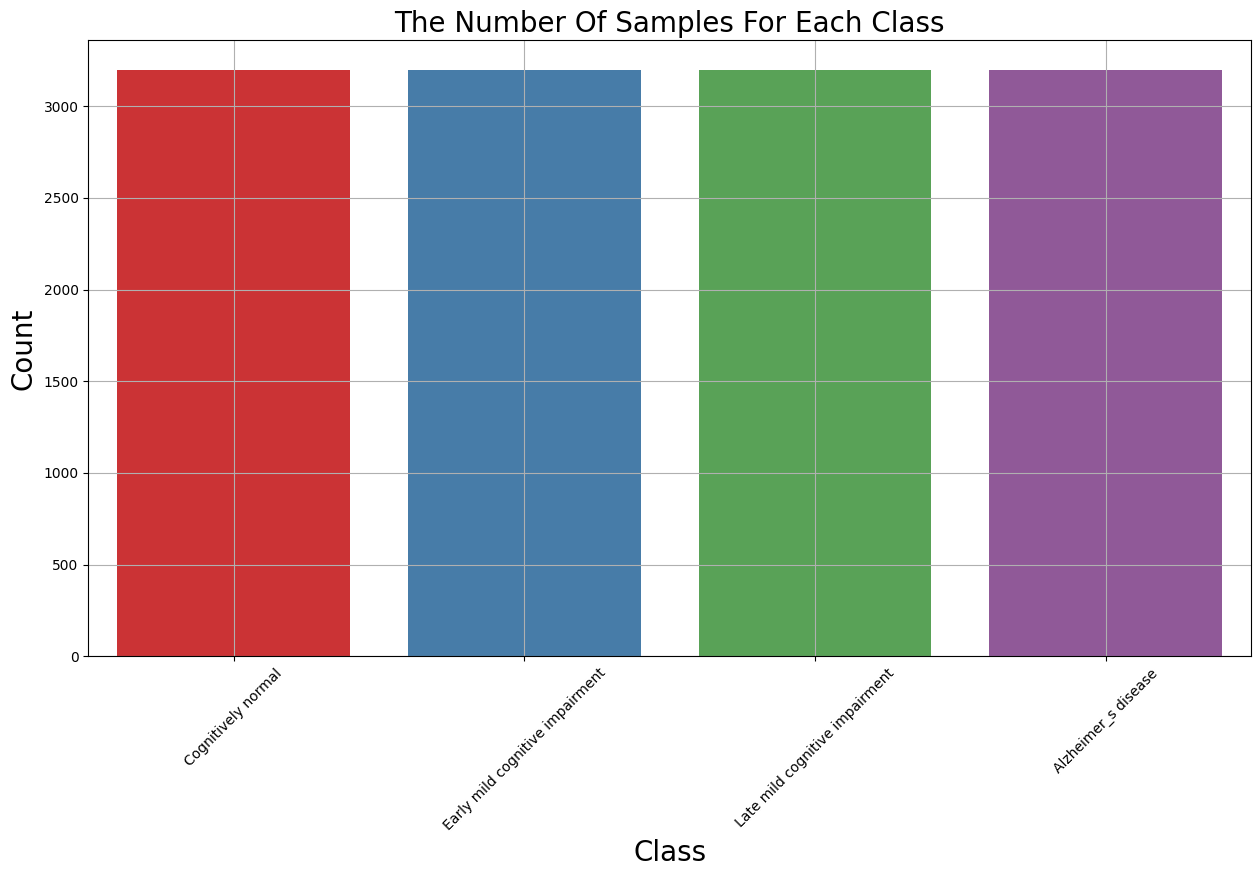

In [12]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [13]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
X_val shape is  (1920, 176, 176, 3)
y_train shape is  (8960, 4)
y_test shape is  (1920, 4)
y_val shape is  (1920, 4)


<a id="10"></a>
# <p style="font-family:camtasia;font-size:120%;color:purple;text-align:center;border-radius:15px 50px; padding:7px">CNN Modeling </p>


In [14]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(176,176,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(4,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 88, 88, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 44, 44, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 128)         0

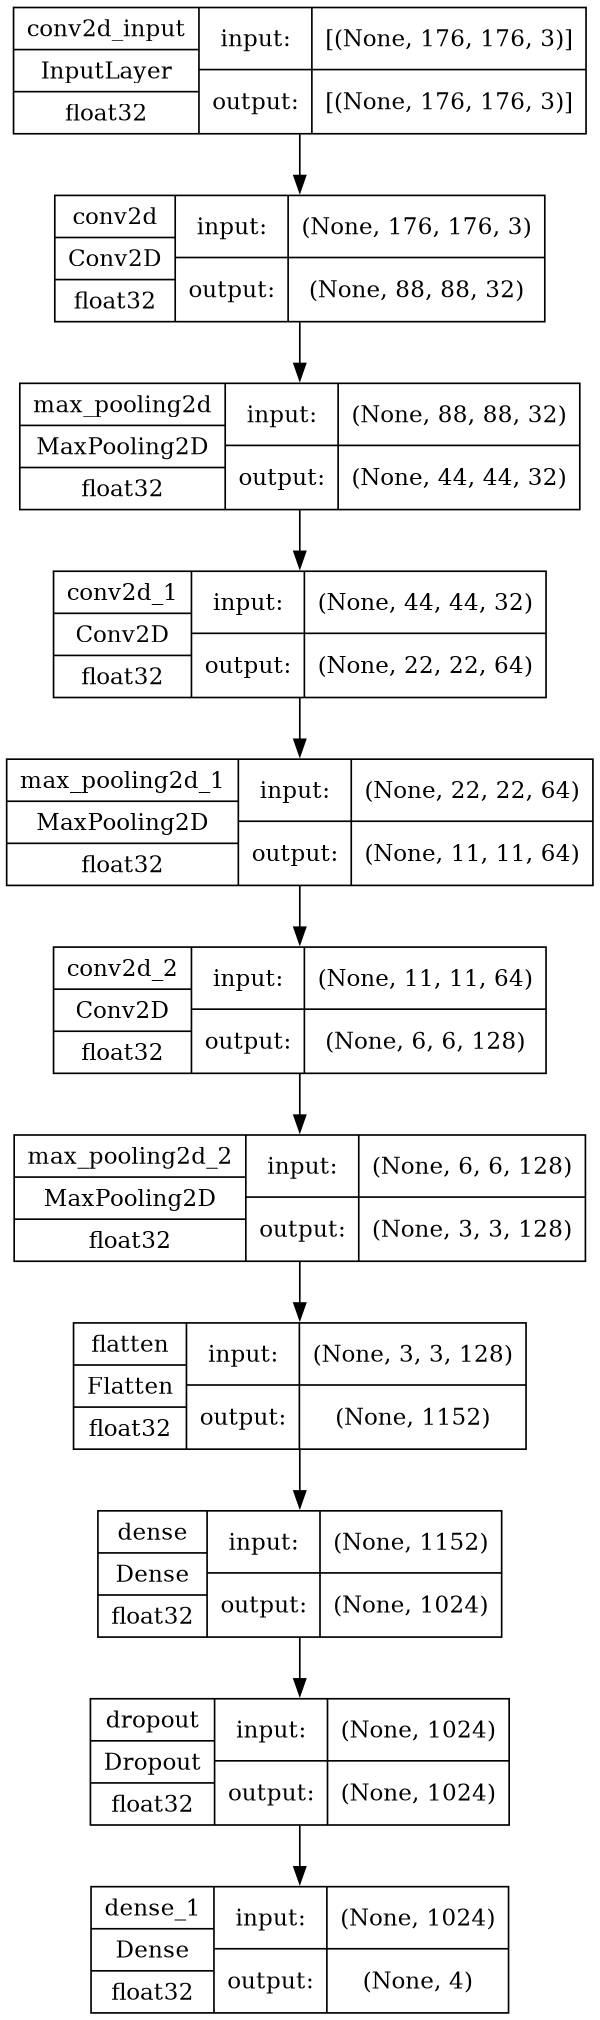

In [15]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [16]:
checkpoint_cb =ModelCheckpoint("CNN_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=50, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
280/280 [==============================] - 16s 19ms/step - loss: 0.8357 - accuracy: 0.5996 - val_loss: 0.6418 - val_accuracy: 0.7161
Epoch 2/50
  6/280 [..............................] - ETA: 3s - loss: 0.5636 - accuracy: 0.7552

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/280 [==============================] - 3s 12ms/step - loss: 0.3842 - accuracy: 0.8316 - val_loss: 0.2686 - val_accuracy: 0.8906
Epoch 3/50
280/280 [==============================] - 3s 12ms/step - loss: 0.2032 - accuracy: 0.9175 - val_loss: 0.1958 - val_accuracy: 0.9281
Epoch 4/50
280/280 [==============================] - 3s 12ms/step - loss: 0.1162 - accuracy: 0.9587 - val_loss: 0.1184 - val_accuracy: 0.9599
Epoch 5/50
280/280 [==============================] - 3s 12ms/step - loss: 0.0639 - accuracy: 0.9772 - val_loss: 0.0851 - val_accuracy: 0.9677
Epoch 6/50
280/280 [==============================] - 3s 11ms/step - loss: 0.0585 - accuracy: 0.9783 - val_loss: 0.0929 - val_accuracy: 0.9688
Epoch 7/50
280/280 [==============================] - 3s 12ms/step - loss: 0.0318 - accuracy: 0.9871 - val_loss: 0.1457 - val_accuracy: 0.9536
Epoch 8/50
280/280 [==============================] - 3s 12ms/step - loss: 0.0360 - accuracy: 0.9868 - val_loss: 0.0831 - val_accuracy: 0.9708
Epoch 9/50

<a id="11"></a>
# <p style="color:purple;text-align:center;border-radius:15px 50px; padding:7px"> Evaluating the Model  </p>


In [17]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0   0.835665  0.599554  0.641781      0.716146
1   0.384175  0.831585  0.268605      0.890625
2   0.203218  0.917522  0.195818      0.928125
3   0.116178  0.958705  0.118413      0.959896
4   0.063930  0.977232  0.085082      0.967708
5   0.058532  0.978348  0.092900      0.968750
6   0.031832  0.987054  0.145726      0.953646
7   0.036037  0.986830  0.083080      0.970833
8   0.047086  0.985045  0.062218      0.980729
9   0.011964  0.996094  0.084580      0.972396
10  0.013149  0.995536  0.084959      0.965625
11  0.017341  0.994420  0.113969      0.969271
12  0.044634  0.983594  0.139060      0.952604
13  0.023509  0.992299  0.079347      0.980208
14  0.022452  0.992969  0.091147      0.970833
15  0.034669  0.987165  0.068894      0.976562
16  0.003483  0.998661  0.076742      0.980729
17  0.000239  1.000000  0.034064      0.989583
18  0.000063  1.000000  0.035461      0.990625
19  0.000058  1.000000  0.039644      0.990104
20  0.000026  1.000000  0.039981      0.989583
21  0.000019  1.000000  0.039476      0.990104
22  0.000017  1.000000  0.038888      0.990104
23  0.000016  1.000000  0.039512      0.989583
24  0.000012  1.000000  0.038937      0.990625
25  0.000009  1.000000  0.040207      0.990104
26  0.000007  1.000000  0.039804      0.990104
27  0.000008  1.000000  0.040986      0.990104

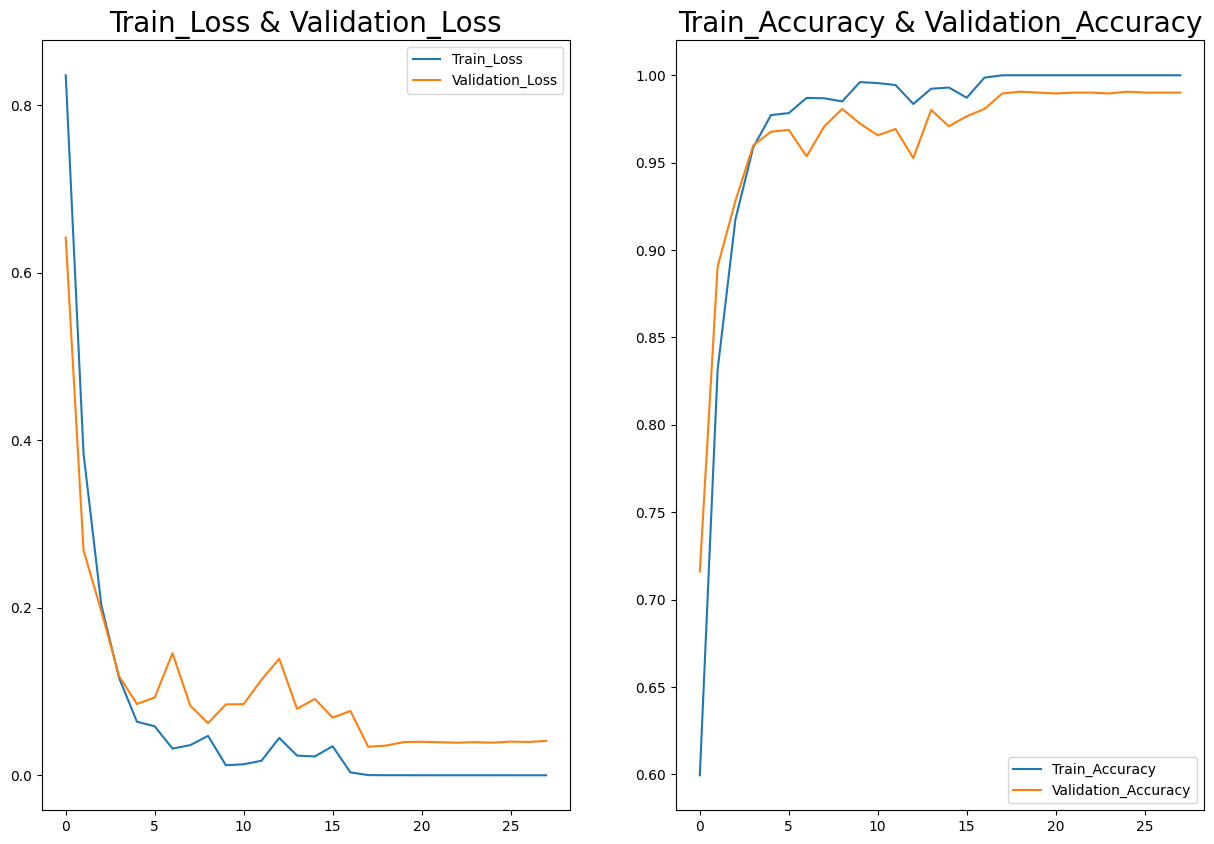

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [19]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 [==============================] - 0s 8ms/step - loss: 0.0381 - accuracy: 0.9911
Test Loss = 0.038098547607660294
Test Accuracy = 0.9911458492279053


In [20]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

60/60 [==============================] - 1s 7ms/step


Actual  Prediction
0          1           1
1          1           1
2          0           0
3          2           2
4          2           2
...      ...         ...
1915       2           2
1916       0           0
1917       2           2
1918       3           3
1919       3           3

[1920 rows x 2 columns]

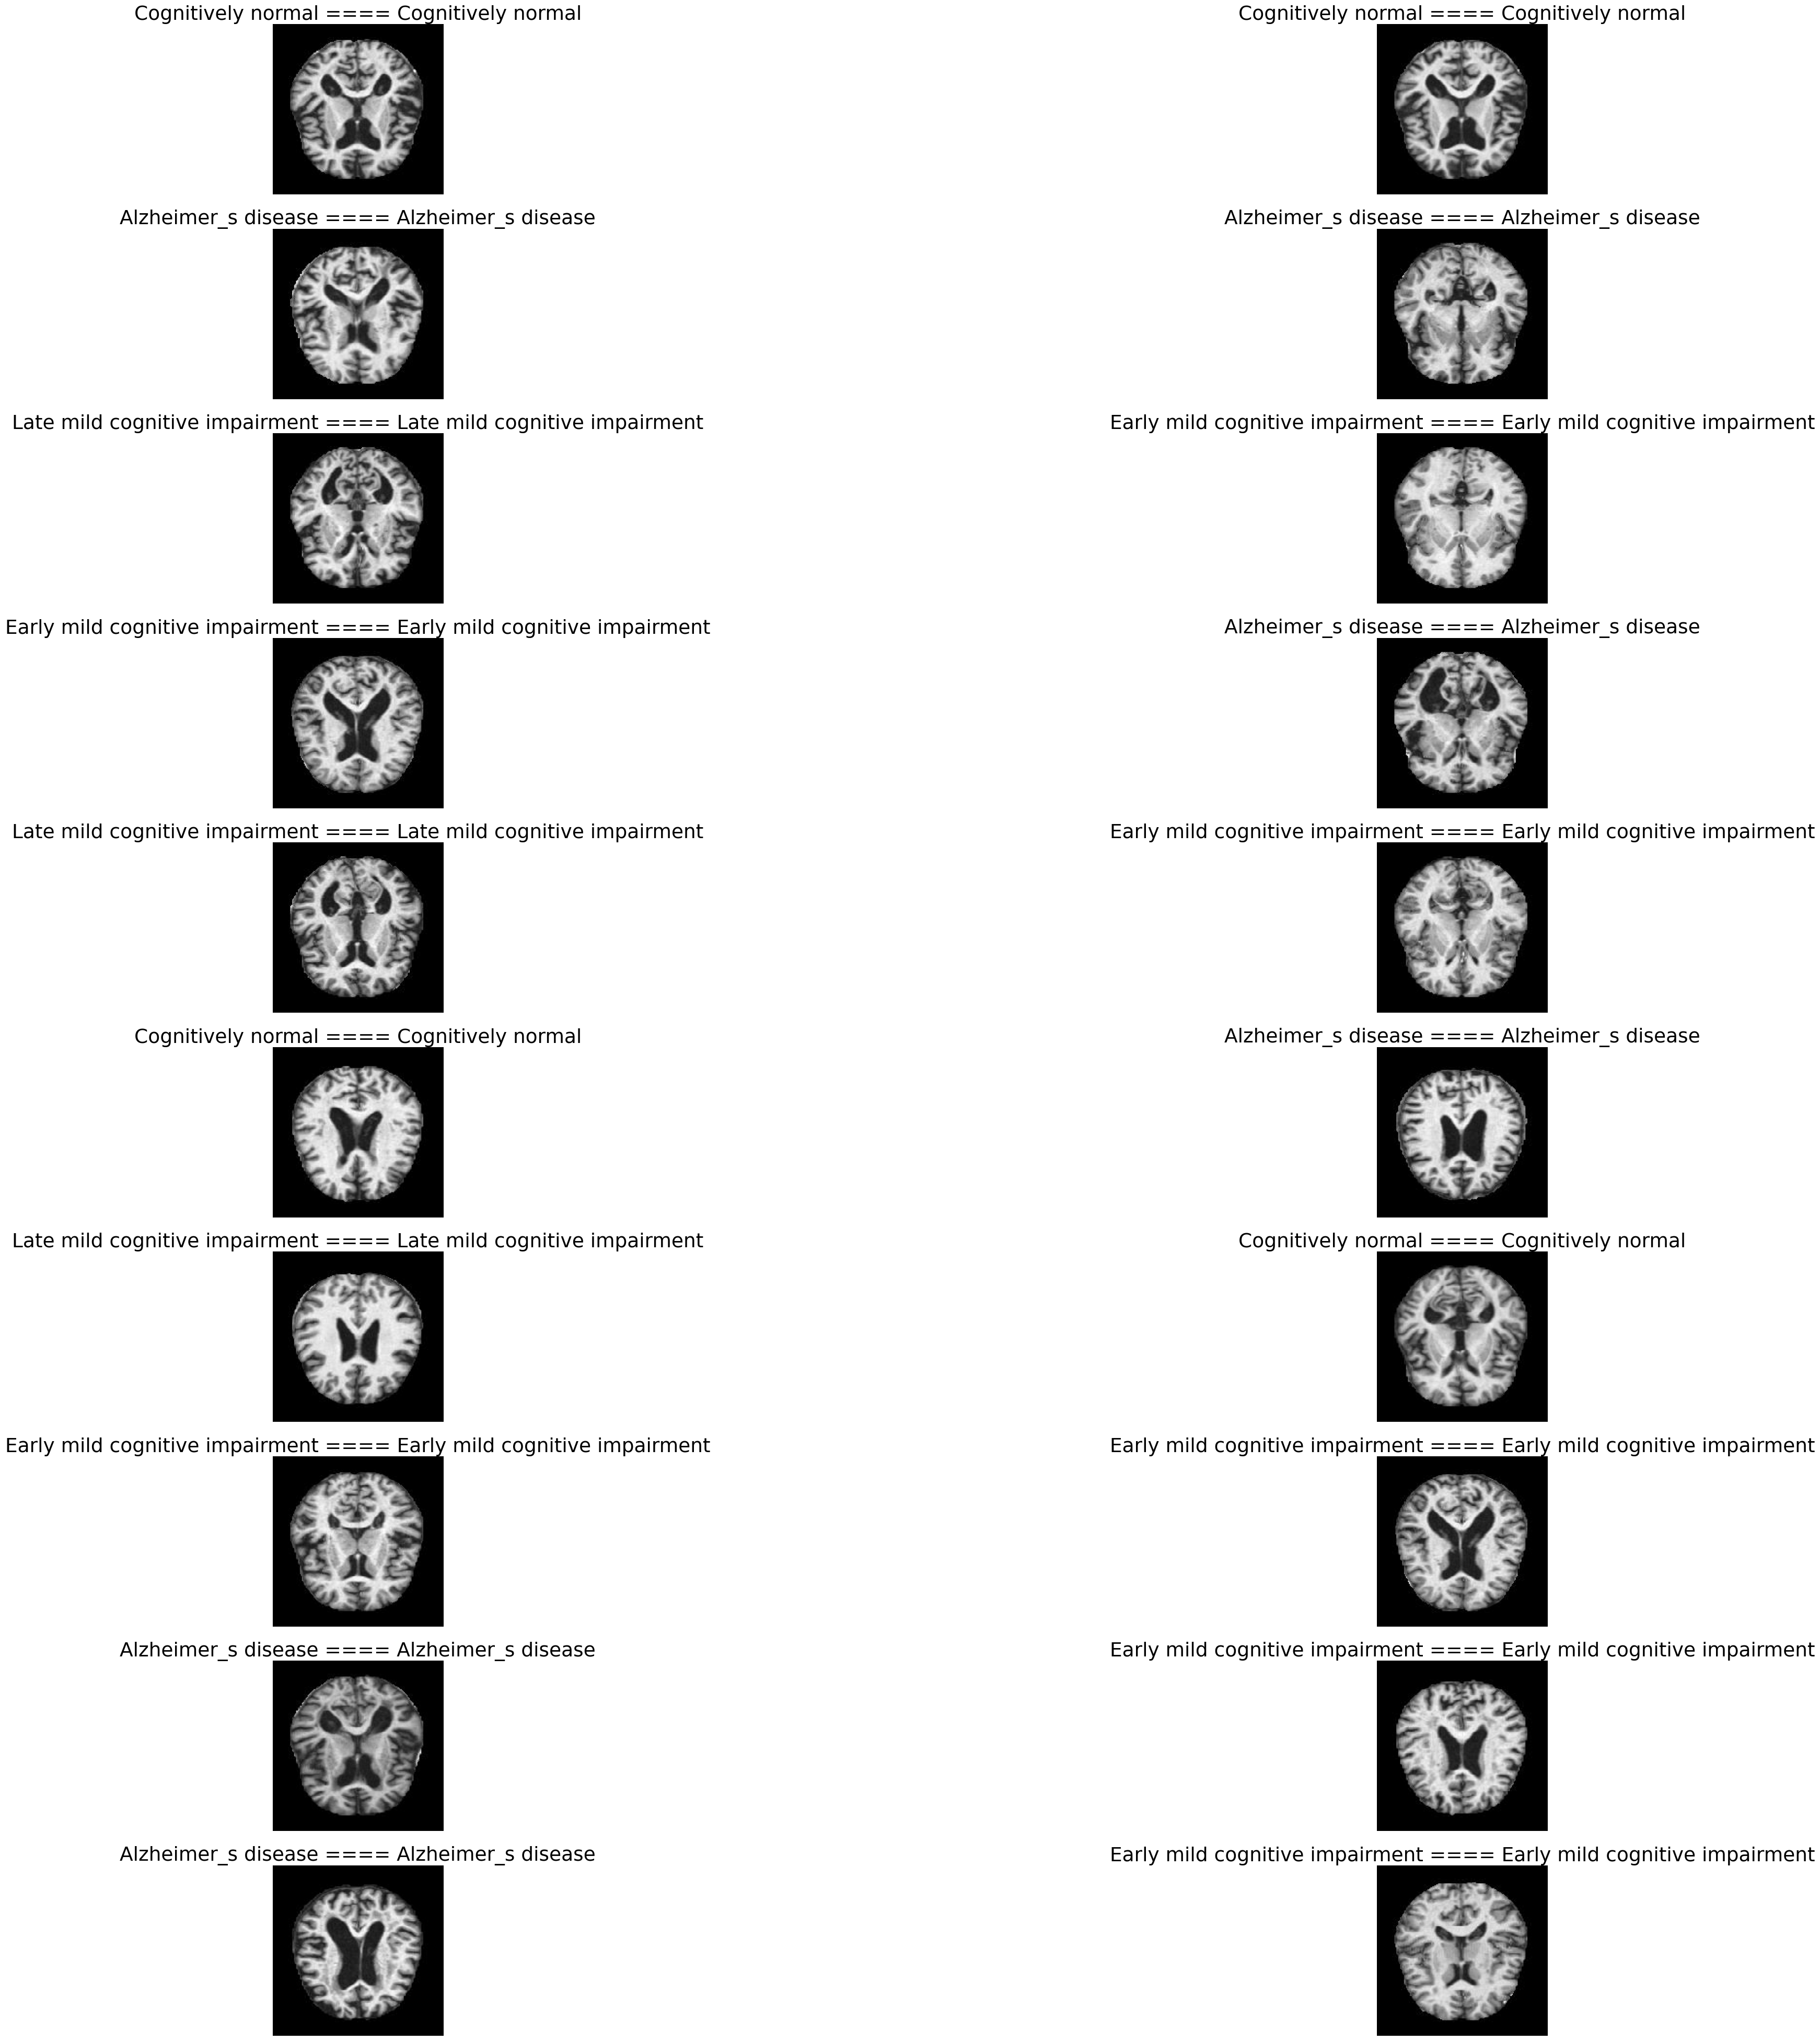

In [28]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(X_test),20)):
    plt.subplot(10,2,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} ==== {class_num[y_pred[i]]}',fontsize=27)

array([[479,   0,   0,   1],
       [  0, 480,   0,   0],
       [  4,   0, 470,   6],
       [  2,   0,   4, 474]])

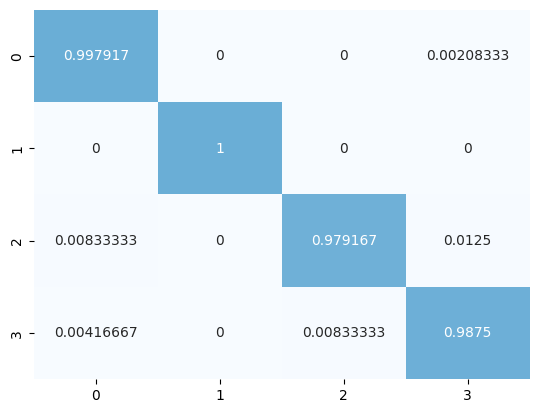

In [29]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [30]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      1.00      0.99       480
           1       1.00      1.00      1.00       480
           2       0.99      0.98      0.99       480
           3       0.99      0.99      0.99       480

    accuracy                           0.99      1920
   macro avg       0.99      0.99      0.99      1920
weighted avg       0.99      0.99      0.99      1920

